# Model comparison

In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import mean_squared_error

from scripts.model import OptionPricer

In [3]:
sns.set_style("whitegrid")

### Loading data

In [4]:
train = pd.read_parquet(os.path.join("..", "data", "processed", "train.parquet"))
test = pd.read_parquet(os.path.join("..", "data", "processed", "test.parquet"))

In [5]:
train_x, train_y = train.drop("y", axis=1), train["y"]
train_x_tensor, train_y_tensor = (
    torch.from_numpy(train_x.values).float(),
    torch.from_numpy(train_y.values).float(),
)

test_x, test_y = test.drop("y", axis=1), test["y"]
test_x_tensor, test_y_tensor = (
    torch.from_numpy(test_x.values).float(),
    torch.from_numpy(test_y.values).float(),
)

random_train = np.random.choice(train_x.index, size=1000, replace=False)
random_test = np.random.choice(test_x.index, size=1000, replace=False)

## DNN

In [6]:
optionpricer = OptionPricer(2, 80)
optionpricer.load_state_dict(torch.load(os.path.join("../", "models", "nn.pt")))

<All keys matched successfully>

In [7]:
optionpricer.eval()
nn_train_pred = optionpricer(train_x_tensor).detach().numpy()
nn_test_pred = optionpricer(test_x_tensor).detach().numpy()

### RMSEs

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [9]:
rmse(nn_train_pred, train_y.values), rmse(nn_test_pred, test_y.values)

(4.144720069534647, 4.154784952996911)

### Predicted vs real plots

In [10]:
def pred_vs_real_plot(pred, real, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.regplot(x=pred, y=real, scatter_kws={"alpha": 0.5}, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    ax.set_title(title)
    return fig, ax

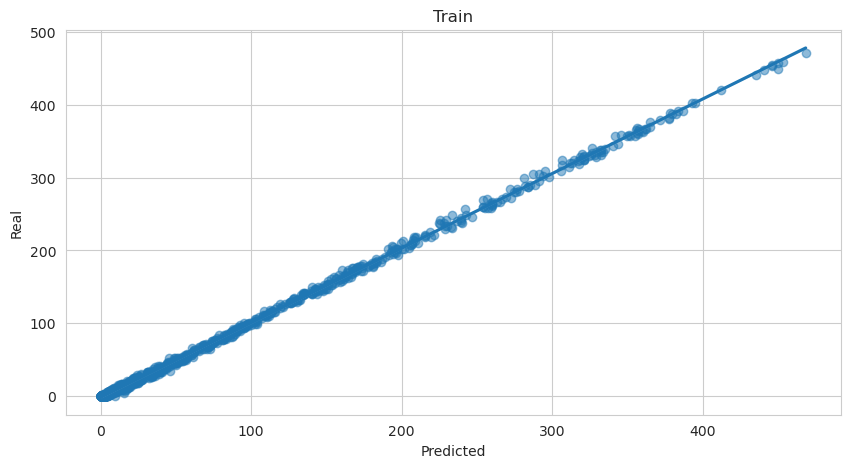

In [11]:
pred_vs_real_plot(nn_train_pred[random_train], train_y.values[random_train], "Train")
plt.show()

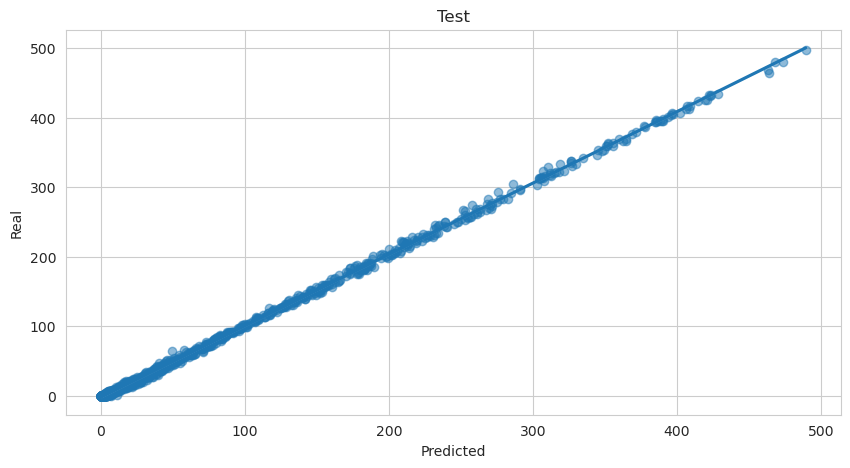

In [12]:
pred_vs_real_plot(nn_test_pred[random_test, :], test_y[random_test], "Test")
plt.show()

### Moneyness dependende

In [11]:
raw_data_train = pd.read_parquet(os.path.join("..", "data", "raw", "train.parquet")).iloc[random_train]
raw_data_test = pd.read_parquet(os.path.join("..", "data", "raw", "test.parquet")).iloc[random_test]

In [12]:
moneyness_train = (raw_data_train["S"]- raw_data_train["K"]).values
moneyness_test = (raw_data_test["S"] - raw_data_test["K"]).values

errors_train = np.abs(nn_train_pred[random_train].flatten() - train_y.values[random_train])
errors_test = np.abs(nn_test_pred[random_test, :].flatten() - test_y.values[random_test])

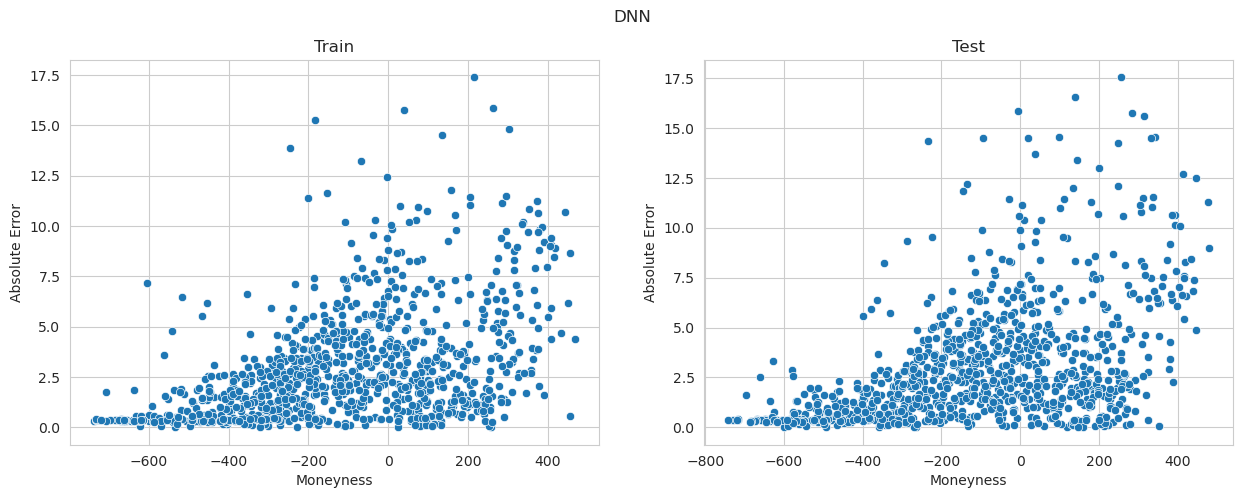

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=moneyness_train, y=errors_train, ax=ax[0])
ax[0].set_title("Train")
ax[0].set_xlabel("Moneyness")
ax[0].set_ylabel("Absolute Error")

sns.scatterplot(x=moneyness_test, y=errors_test, ax=ax[1])
ax[1].set_title("Test")
ax[1].set_xlabel("Moneyness")
ax[1].set_ylabel("Absolute Error")
plt.suptitle("DNN")
plt.savefig(os.path.join("..", "figures", "nn_errors.png"))
plt.show()

## RandomForest

In [14]:
# read rf model from pickle "rf.pkl" in directory ../models


with open(os.path.join("../", "models", "rf.pkl"), "rb") as f:
    rf = pickle.load(f)

rf_train_pred = rf.predict(train_x)
rf_test_pred = rf.predict(test_x)

Let's do the same analysis for RF model as previously for neural network.

In [15]:
rmse(rf_train_pred, train_y.values), rmse(rf_test_pred, test_y.values)

(6.566414539351977, 6.995139150255578)

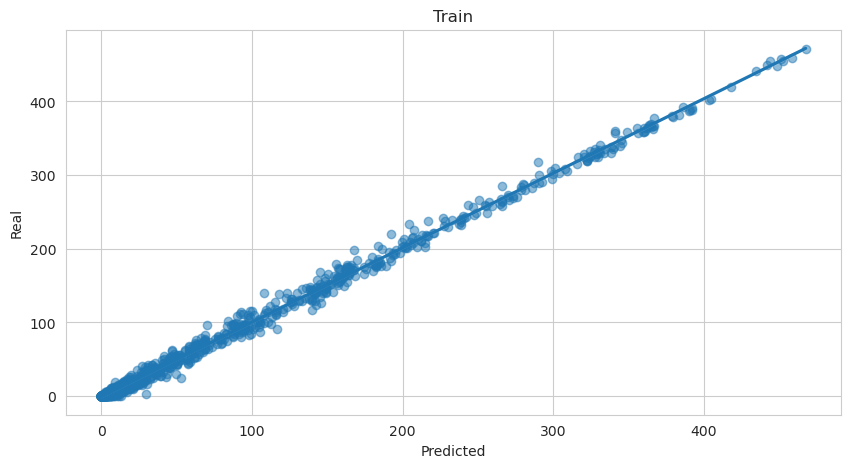

In [17]:
pred_vs_real_plot(rf_train_pred[random_train], train_y.values[random_train], "Train")
plt.show()

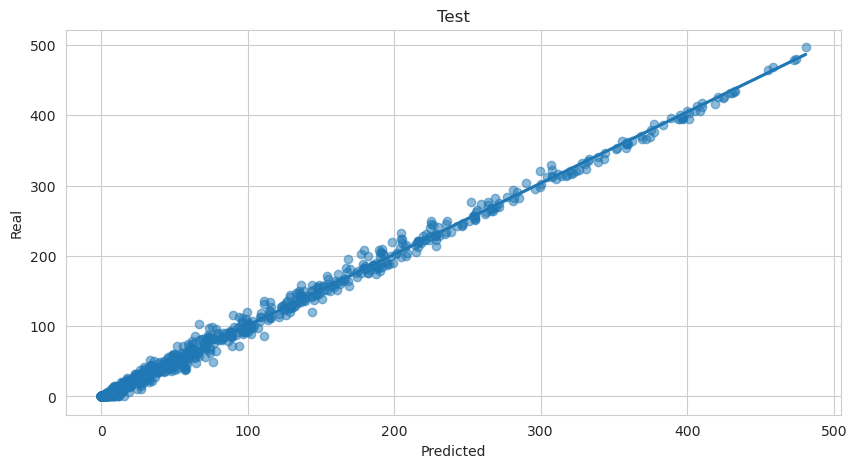

In [18]:
pred_vs_real_plot(rf_test_pred[random_test], test_y.values[random_test], "Test")
plt.show()

In [16]:
errors_train = np.abs(rf_train_pred[random_train] - train_y.values[random_train])
errors_test = np.abs(rf_test_pred[random_test] - test_y.values[random_test])

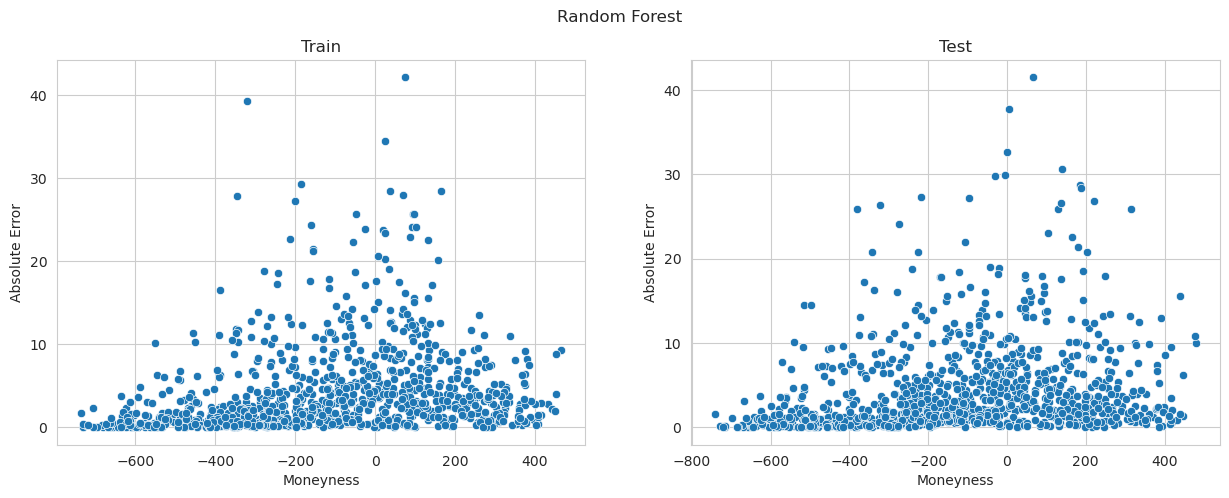

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=moneyness_train, y=errors_train, ax=ax[0])
ax[0].set_title("Train")
ax[0].set_xlabel("Moneyness")
ax[0].set_ylabel("Absolute Error")

sns.scatterplot(x=moneyness_test, y=errors_test, ax=ax[1])
ax[1].set_title("Test")
ax[1].set_xlabel("Moneyness")
ax[1].set_ylabel("Absolute Error")

plt.suptitle("Random Forest")
plt.savefig(os.path.join("..", "figures", "rf_errors.png"))
plt.show()

# Conclusion
The results for neural network are slighly better.